<a href="https://colab.research.google.com/github/lottle2008/MOOCCube-Transformer-Recommendation/blob/main/lun1_lun2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📘 Notebook 1：01_data_preparation.ipynb

目标：

从 lun1 提供的数据（或原始 MOOC-CubeX）中提取用户、视频、概念、观看日志；

清洗、标准化；

计算行为特征；

保存成四个标准 CSV，供下一阶段使用。

In [1]:
!pip install pandas numpy tqdm


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# 设置随机种子
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 数据目录
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)


In [3]:
# 检查是否已有数据
expected_files = ["users.csv", "videos.csv", "concepts.csv", "watch_logs.csv"]
existing = [f for f in expected_files if os.path.exists(os.path.join(DATA_DIR, f))]
if len(existing) == 4:
    print("✅ Found all required CSV files. Proceeding...")
else:
    print("⚠️ Data files not found. Generating small demo dataset for pipeline testing...")
    users = pd.DataFrame({"user_id": [f"u{i}" for i in range(1, 51)]})
    concepts = pd.DataFrame({"concept_id": [f"c{i}" for i in range(1, 31)],
                             "concept_name":[f"concept_{i}" for i in range(1,31)]})
    videos = []
    logs = []
    for vid in range(1, 101):
        vid_id = f"v{vid}"
        # 每个视频随机绑定 1~3 个概念
        cons = random.sample(list(concepts.concept_id), k=random.choice([1,2,3]))
        videos.append({"video_id": vid_id,
                       "title": f"Video {vid}",
                       "duration": random.choice([300,600,900]),
                       "concept_ids": ",".join(cons)})
    for user in users.user_id:
        watched = random.sample([v["video_id"] for v in videos], k=random.randint(5,20))
        for v in watched:
            dur = next(item for item in videos if item["video_id"]==v)["duration"]
            wt = int(dur * random.uniform(0.1,1.0))
            comp = wt / dur
            speed = random.choice([1.0,1.25,1.5])
            logs.append({"user_id": user, "video_id": v,
                         "watch_time": wt, "video_duration": dur,
                         "completion_rate": comp, "avg_playback_speed": speed})
    videos = pd.DataFrame(videos)
    logs = pd.DataFrame(logs)
    users.to_csv(os.path.join(DATA_DIR,"users.csv"), index=False)
    videos.to_csv(os.path.join(DATA_DIR,"videos.csv"), index=False)
    concepts.to_csv(os.path.join(DATA_DIR,"concepts.csv"), index=False)
    logs.to_csv(os.path.join(DATA_DIR,"watch_logs.csv"), index=False)
    print("✅ Demo data generated and saved.")


⚠️ Data files not found. Generating small demo dataset for pipeline testing...
✅ Demo data generated and saved.


In [4]:
# 载入数据
users_df = pd.read_csv(os.path.join(DATA_DIR,"users.csv"))
videos_df = pd.read_csv(os.path.join(DATA_DIR,"videos.csv"))
concepts_df = pd.read_csv(os.path.join(DATA_DIR,"concepts.csv"))
logs_df = pd.read_csv(os.path.join(DATA_DIR,"watch_logs.csv"))

print("原始日志样例：")
display(logs_df.head())

# === 特征计算 ===
# 1. 用户层特征
user_stats = logs_df.groupby("user_id").agg(
    avg_completion=("completion_rate","mean"),
    avg_speed=("avg_playback_speed","mean"),
    total_watch_time=("watch_time","sum"),
    total_videos=("video_id","count")
).reset_index()

# 2. 视频层特征
video_stats = logs_df.groupby("video_id").agg(
    avg_completion=("completion_rate","mean"),
    avg_watch_time=("watch_time","mean"),
    total_views=("user_id","count")
).reset_index()

# 合并保存
users_df = users_df.merge(user_stats, on="user_id", how="left").fillna(0)
videos_df = videos_df.merge(video_stats, on="video_id", how="left").fillna(0)

# 保存更新后的文件
users_df.to_csv(os.path.join(DATA_DIR,"users.csv"), index=False)
videos_df.to_csv(os.path.join(DATA_DIR,"videos.csv"), index=False)

print("✅ 行为特征已计算并更新到 CSV。")


原始日志样例：


,user_id,video_id,watch_time,video_duration,completion_rate,avg_playback_speed
0,u1,v31,149,900,0.165556,1.00
1,u1,v34,166,300,0.553333,1.00
2,u1,v51,281,300,0.936667,1.00
3,u1,v17,534,600,0.890000,1.25
4,u1,v86,320,900,0.355556,1.25


✅ 行为特征已计算并更新到 CSV。


In [5]:
video_concept_edges = []
for _, row in videos_df.iterrows():
    c_list = [c.strip() for c in str(row["concept_ids"]).split(",") if c.strip()]
    for c in c_list:
        video_concept_edges.append({"video_id": row["video_id"], "concept_id": c})

edges_df = pd.DataFrame(video_concept_edges)
edges_df.to_csv(os.path.join(DATA_DIR, "video_concept_edges.csv"), index=False)
print("✅ 已保存 video–concept 边表，共", len(edges_df), "条记录。")


✅ 已保存 video–concept 边表，共 207 条记录。


In [6]:
print("用户数:", len(users_df))
print("视频数:", len(videos_df))
print("概念数:", len(concepts_df))
print("日志数:", len(logs_df))
print("边数:", len(edges_df))

# 简单完整性检查
assert logs_df["user_id"].isin(users_df["user_id"]).all(), "日志中有未知用户"
assert logs_df["video_id"].isin(videos_df["video_id"]).all(), "日志中有未知视频"
assert edges_df["concept_id"].isin(concepts_df["concept_id"]).all(), "存在未知概念"
print("✅ 数据完整性检查通过。")


用户数: 50
视频数: 100
概念数: 30
日志数: 601
边数: 207
✅ 数据完整性检查通过。


In [8]:
print(
"数据准备完成！输出结果：\n"
"- users.csv（含行为特征）\n"
"- videos.csv（含视频统计）\n"
"- concepts.csv（概念基础表）\n"
"- watch_logs.csv（观看日志）\n"
"- video_concept_edges.csv（视频-概念映射）\n\n"
"✅ 下一步：在 02_HIN_GCN_training.ipynb 中载入这些文件，构建异构图并训练 GCN。"
)

数据准备完成！输出结果：
- users.csv（含行为特征）
- videos.csv（含视频统计）
- concepts.csv（概念基础表）
- watch_logs.csv（观看日志）
- video_concept_edges.csv（视频-概念映射）

✅ 下一步：在 02_HIN_GCN_training.ipynb 中载入这些文件，构建异构图并训练 GCN。


🧠 研究阶段 2：HIN + GCN 模型训练

目标：

从数据文件中构建异构信息网络（HIN），节点包含用户（User）、视频（Video）、概念（Concept）。

基于元路径构造邻接关系。

使用单层 GCN（Graph Convolutional Network） 学习用户与概念的嵌入表示。

保存训练结果 user_embs.npy, concept_embs.npy，供下一阶段推荐模型使用。

In [9]:
!pip install torch torchvision torchaudio torch-geometric tqdm pandas numpy scipy scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00


In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from tqdm import tqdm
import random

# 固定随机种子
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", DEVICE)


✅ Using device: cuda


In [11]:
DATA_DIR = "/content/data"

users_df = pd.read_csv(os.path.join(DATA_DIR, "users.csv"))
videos_df = pd.read_csv(os.path.join(DATA_DIR, "videos.csv"))
concepts_df = pd.read_csv(os.path.join(DATA_DIR, "concepts.csv"))
logs_df = pd.read_csv(os.path.join(DATA_DIR, "watch_logs.csv"))
edges_df = pd.read_csv(os.path.join(DATA_DIR, "video_concept_edges.csv"))

print(f"✅ 数据加载完成: {len(users_df)} 用户, {len(videos_df)} 视频, {len(concepts_df)} 概念, {len(logs_df)} 日志")


✅ 数据加载完成: 50 用户, 100 视频, 30 概念, 601 日志


In [12]:
user2idx = {u: i for i, u in enumerate(users_df["user_id"].unique())}
video2idx = {v: i for i, v in enumerate(videos_df["video_id"].unique())}
concept2idx = {c: i for i, c in enumerate(concepts_df["concept_id"].unique())}

num_users = len(user2idx)
num_videos = len(video2idx)
num_concepts = len(concept2idx)

print(f"用户节点数: {num_users}, 视频节点数: {num_videos}, 概念节点数: {num_concepts}")


用户节点数: 50, 视频节点数: 100, 概念节点数: 30


In [13]:
# 1️⃣ 用户-视频边
uv_edges = logs_df[["user_id", "video_id"]].drop_duplicates()
uv_edges["u_idx"] = uv_edges["user_id"].map(user2idx)
uv_edges["v_idx"] = uv_edges["video_id"].map(video2idx)

# 2️⃣ 视频-概念边
vc_edges = edges_df.copy()
vc_edges["v_idx"] = vc_edges["video_id"].map(video2idx)
vc_edges["c_idx"] = vc_edges["concept_id"].map(concept2idx)

# 3️⃣ 用户-用户共现（观看同一视频）
video_to_users = logs_df.groupby("video_id")["user_id"].apply(list).to_dict()
uu_pairs = set()
for vid, users in video_to_users.items():
    for i in range(len(users)):
        for j in range(i + 1, len(users)):
            uu_pairs.add((user2idx[users[i]], user2idx[users[j]]))
uu_edges = pd.DataFrame(list(uu_pairs), columns=["u1_idx", "u2_idx"])

# 4️⃣ 概念-概念共现（同视频内）
video_to_concepts = edges_df.groupby("video_id")["concept_id"].apply(list).to_dict()
cc_pairs = set()
for vid, cons in video_to_concepts.items():
    for i in range(len(cons)):
        for j in range(i + 1, len(cons)):
            cc_pairs.add((concept2idx[cons[i]], concept2idx[cons[j]]))
cc_edges = pd.DataFrame(list(cc_pairs), columns=["c1_idx", "c2_idx"])

print(f"用户-视频边: {len(uv_edges)} | 视频-概念边: {len(vc_edges)} | U-U 边: {len(uu_edges)} | C-C 边: {len(cc_edges)}")


用户-视频边: 601 | 视频-概念边: 207 | U-U 边: 894 | C-C 边: 139


In [14]:
from scipy.sparse import coo_matrix

# 用户-用户邻接
rows, cols = uu_edges["u1_idx"].values, uu_edges["u2_idx"].values
user_adj = coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(num_users, num_users))

# 概念-概念邻接
rows, cols = cc_edges["c1_idx"].values, cc_edges["c2_idx"].values
concept_adj = coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(num_concepts, num_concepts))

print("✅ 构建稀疏矩阵完成：")
print(f"User adj nnz: {user_adj.nnz}, Concept adj nnz: {concept_adj.nnz}")


✅ 构建稀疏矩阵完成：
User adj nnz: 894, Concept adj nnz: 139


In [15]:
class SimpleGCN(nn.Module):
    def __init__(self, num_nodes, emb_dim=64):
        super().__init__()
        self.node_emb = nn.Parameter(torch.randn(num_nodes, emb_dim))
        self.conv = GCNConv(emb_dim, emb_dim)

    def forward(self, edge_index, edge_weight=None):
        x = self.node_emb
        x = self.conv(x, edge_index, edge_weight)
        x = F.relu(x)
        return x


In [16]:
from torch_geometric.utils import from_scipy_sparse_matrix

def train_gcn(adj_matrix, num_nodes, emb_dim=64, epochs=50, lr=0.01):
    edge_index, edge_weight = from_scipy_sparse_matrix(adj_matrix)
    edge_index, edge_weight = edge_index.to(DEVICE), edge_weight.to(DEVICE)
    model = SimpleGCN(num_nodes, emb_dim).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    pos_u = edge_index[0]
    pos_v = edge_index[1]

    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        z = model(edge_index, edge_weight)
        pos_score = (z[pos_u] * z[pos_v]).sum(dim=1)
        neg_v = torch.randint(0, num_nodes, pos_v.shape, device=DEVICE)
        neg_score = (z[pos_u] * z[neg_v]).sum(dim=1)
        loss = - (F.logsigmoid(pos_score).mean() + F.logsigmoid(-neg_score).mean())
        loss.backward()
        opt.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
    model.eval()
    with torch.no_grad():
        emb = model(edge_index, edge_weight).cpu().numpy()
    return emb


In [17]:
EMB_DIM = 64

print("🧠 训练用户 GCN ...")
user_embs = train_gcn(user_adj, num_users, emb_dim=EMB_DIM, epochs=40, lr=0.01)
print("✅ 用户嵌入 shape:", user_embs.shape)

print("\n🧠 训练概念 GCN ...")
concept_embs = train_gcn(concept_adj, num_concepts, emb_dim=EMB_DIM, epochs=40, lr=0.01)
print("✅ 概念嵌入 shape:", concept_embs.shape)


🧠 训练用户 GCN ...
Epoch 000 | Loss: 7.8597
Epoch 010 | Loss: 1.3864
Epoch 020 | Loss: 1.3865
Epoch 030 | Loss: 1.3863
✅ 用户嵌入 shape: (50, 64)

🧠 训练概念 GCN ...
Epoch 000 | Loss: 2.7954
Epoch 010 | Loss: 1.3813
Epoch 020 | Loss: 1.3651
Epoch 030 | Loss: 1.3462
✅ 概念嵌入 shape: (30, 64)


In [18]:
np.save(os.path.join(DATA_DIR, "user_embs.npy"), user_embs)
np.save(os.path.join(DATA_DIR, "concept_embs.npy"), concept_embs)

print("✅ 嵌入保存完成：")
print("user_embs.npy, concept_embs.npy 已写入", DATA_DIR)


✅ 嵌入保存完成：
user_embs.npy, concept_embs.npy 已写入 /content/data


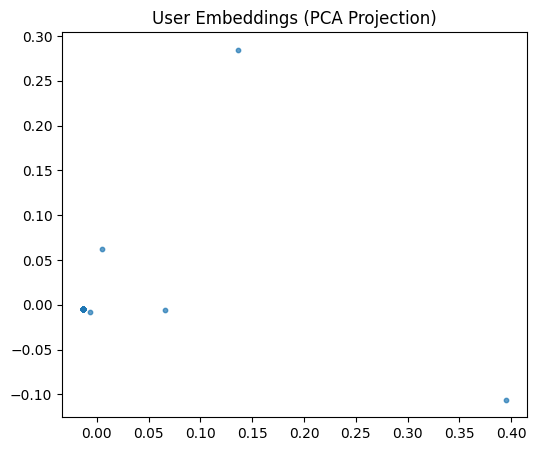

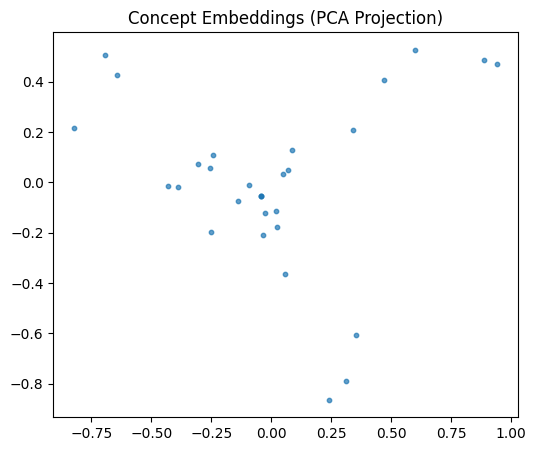

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(embeddings, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(6,5))
    plt.scatter(reduced[:,0], reduced[:,1], s=10, alpha=0.7)
    plt.title(title)
    plt.show()

visualize_embeddings(user_embs, "User Embeddings (PCA Projection)")
visualize_embeddings(concept_embs, "Concept Embeddings (PCA Projection)")


In [21]:
print(
"第二阶段完成！\n"
"输出结果：\n"
"- user_embs.npy  （用户节点嵌入）\n"
"- concept_embs.npy （概念节点嵌入）\n"
"支撑第三阶段的推荐模型训练\n\n"
"下一阶段 (03_recommendation_model.ipynb)：\n"
"👉 将加载这些嵌入与行为特征\n"
"👉 训练“融合 GCN + 行为特征”的推荐模型\n"
"👉 评估 Precision@K、Recall@K、NDCG"
)

第二阶段完成！
输出结果：
- user_embs.npy  （用户节点嵌入）
- concept_embs.npy （概念节点嵌入）
支撑第三阶段的推荐模型训练

下一阶段 (03_recommendation_model.ipynb)：
👉 将加载这些嵌入与行为特征
👉 训练“融合 GCN + 行为特征”的推荐模型
👉 评估 Precision@K、Recall@K、NDCG


In [22]:
# 可选：检查 GPU
import torch
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())


torch: 2.8.0+cu126 cuda: True


In [23]:
!pip install --upgrade pip
!pip install pandas numpy scipy scikit-learn tqdm matplotlib seaborn
# PyTorch is usually preinstalled on Colab. If not, uncomment below and adjust cuda version.
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [24]:
import os, random, math, time
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [25]:
DATA_DIR = "/content/data"  # 修改为你的路径（前两个 Notebook 的输出）
# CSVs
users_df = pd.read_csv(os.path.join(DATA_DIR,"users.csv"))
videos_df = pd.read_csv(os.path.join(DATA_DIR,"videos.csv"))
concepts_df = pd.read_csv(os.path.join(DATA_DIR,"concepts.csv"))
logs_df = pd.read_csv(os.path.join(DATA_DIR,"watch_logs.csv"))
edges_df = pd.read_csv(os.path.join(DATA_DIR,"video_concept_edges.csv"))

# Embeddings from stage 2
user_emb_path = os.path.join(DATA_DIR, "user_embs.npy")
concept_emb_path = os.path.join(DATA_DIR, "concept_embs.npy")
if not os.path.exists(user_emb_path) or not os.path.exists(concept_emb_path):
    raise FileNotFoundError("找不到 user_embs.npy 或 concept_embs.npy，请先运行 02_HIN_GCN_training.ipynb")

user_embs = np.load(user_emb_path)
concept_embs = np.load(concept_emb_path)
print("Loaded embeddings:", user_embs.shape, concept_embs.shape)

# Recreate mappings (must match the ones used when creating embeddings)
user2idx = {u:i for i,u in enumerate(users_df["user_id"].unique())}
idx2user = {i:u for u,i in user2idx.items()}
concept2idx = {c:i for i,c in enumerate(concepts_df["concept_id"].unique())}
idx2concept = {i:c for c,i in concept2idx.items()}

num_users = len(user2idx)
num_concepts = len(concept2idx)
print("num_users", num_users, "num_concepts", num_concepts)

# Basic check: embeddings must align with node counts
if user_embs.shape[0] != num_users:
    print("警告: user_embs 行数与 users.csv 中 unique user_id 数不一致。请确保映射一致。")
if concept_embs.shape[0] != num_concepts:
    print("警告: concept_embs 行数与 concepts.csv 不一致。")


Loaded embeddings: (50, 64) (30, 64)
num_users 50 num_concepts 30


In [26]:
# Build user->concept interactions:
# For each log (user_id, video_id), map video->concepts via edges_df
video_to_concepts = edges_df.groupby("video_id")["concept_id"].apply(lambda s: list(s)).to_dict()

user_concept_set = defaultdict(set)
for _, row in logs_df.iterrows():
    u = row["user_id"]
    v = row["video_id"]
    if v in video_to_concepts:
        for c in video_to_concepts[v]:
            user_concept_set[u].add(c)

# Convert to list pairs (u_idx, c_idx)
pairs = []
for u, cons in user_concept_set.items():
    uidx = user2idx.get(u, None)
    if uidx is None: continue
    for c in cons:
        cidx = concept2idx.get(c, None)
        if cidx is None: continue
        pairs.append((uidx, cidx))

print("Total user-concept interactions:", len(pairs))

# Build per-user lists and apply leave-one-out (holdout 1 item per user as test if possible)
from collections import defaultdict
user_pos = defaultdict(list)
for u,c in pairs:
    user_pos[u].append(c)

train_pairs = []
test_pairs = []
for u, clist in user_pos.items():
    if len(clist) == 0:
        continue
    if len(clist) == 1:
        train_pairs.append((u, clist[0]))
    else:
        test_c = random.choice(clist)
        test_pairs.append((u, test_c))
        for c in clist:
            if c != test_c:
                train_pairs.append((u,c))

print("Train len:", len(train_pairs), "Test len:", len(test_pairs))


Total user-concept interactions: 852
Train len: 802 Test len: 50


In [27]:
# We'll use per-user features from users_df if present (avg_speed, avg_completion, total_watch_time)
feat_cols = []
if "avg_speed" in users_df.columns and "avg_completion" in users_df.columns and "total_watch_time" in users_df.columns:
    feat_cols = ["avg_speed","avg_completion","total_watch_time"]
else:
    # If not present, compute from logs_df (fallback)
    tmp = logs_df.groupby("user_id").agg(
        avg_speed=("avg_playback_speed","mean"),
        avg_completion=("completion_rate","mean"),
        total_watch_time=("watch_time","sum")
    ).reset_index()
    users_df = users_df.merge(tmp, on="user_id", how="left").fillna(0)
    feat_cols = ["avg_speed","avg_completion","total_watch_time"]

# Build matrix by user index order
user_feat_df = users_df.set_index("user_id").reindex([idx2user[i] for i in range(num_users)]).fillna(0)
X_user = user_feat_df[feat_cols].values
scaler = StandardScaler()
X_user_scaled = scaler.fit_transform(X_user)
print("User features shape:", X_user_scaled.shape)


User features shape: (50, 3)


In [28]:
import numpy as np
import math

def ndcg_at_k(rank_list, ground_truth, k):
    # rank_list: list of item ids (predicted top-k)
    # ground_truth: set of true item ids (here one item)
    for i, item in enumerate(rank_list[:k]):
        if item in ground_truth:
            return 1.0 / math.log2(i+2)  # i starts at 0
    return 0.0

def evaluate_ranking_scores(score_fn, test_pairs, train_user_pos, num_items, K_list=[5,10], negatives=100):
    # score_fn(user_idx, item_list) -> scores (numpy array)
    results = {f"P@{k}":0.0 for k in K_list}
    results.update({f"R@{k}":0.0 for k in K_list})
    results.update({f"NDCG@{k}":0.0 for k in K_list})
    n_users = len(test_pairs)
    for (u, pos_item) in tqdm(test_pairs):
        # sample negatives that user has not interacted with
        negs = []
        while len(negs) < negatives:
            cand = random.randrange(num_items)
            if cand not in train_user_pos[u] and cand != pos_item:
                negs.append(cand)
        item_list = [pos_item] + negs
        scores = score_fn(u, item_list)
        ranked_idx = np.argsort(-scores)  # indices into item_list
        ranked_items = [item_list[i] for i in ranked_idx]
        for K in K_list:
            topk = ranked_items[:K]
            hit = 1.0 if pos_item in topk else 0.0
            results[f"P@{K}"] += hit / K
            results[f"R@{K}"] += hit
            results[f"NDCG@{K}"] += ndcg_at_k(ranked_items, {pos_item}, K)
    # normalize
    for K in K_list:
        results[f"P@{K}"] /= n_users
        results[f"R@{K}"] /= n_users
        results[f"NDCG@{K}"] /= n_users
    return results


In [29]:
class MFModel(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
    def forward(self, u_idx, i_idx):
        u = self.user_emb(u_idx)
        v = self.item_emb(i_idx)
        score = (u * v).sum(dim=1)
        return score

def train_mf(train_pairs, num_users, num_items, emb_dim=64, epochs=5, neg_ratio=4, batch_size=1024):
    model = MFModel(num_users, num_items, emb_dim).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    bce = nn.BCEWithLogitsLoss()
    # prepare training samples with negatives
    data = []
    train_set = set(train_pairs)
    for (u,i) in train_pairs:
        data.append((u,i,1))
        for _ in range(neg_ratio):
            neg = random.randrange(num_items)
            while (u,neg) in train_set:
                neg = random.randrange(num_items)
            data.append((u,neg,0))
    class PairDataset(Dataset):
        def __init__(self, data): self.data = data
        def __len__(self): return len(self.data)
        def __getitem__(self, idx): return self.data[idx]
    loader = DataLoader(PairDataset(data), batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch in loader:
            u_idx, i_idx, labels = batch
            u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
            i_idx = torch.tensor(i_idx, dtype=torch.long, device=DEVICE)
            labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)
            preds = model(u_idx, i_idx)
            loss = bce(preds, labels)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item() * len(labels)
        print(f"MF Epoch {epoch} avg_loss {total_loss/len(loader.dataset):.6f}")
    return model

# Train MF (items = concepts)
print("Training MF baseline...")
mf_model = train_mf(train_pairs, num_users, num_concepts, emb_dim=64, epochs=6, neg_ratio=4, batch_size=2048)


Training MF baseline...
MF Epoch 0 avg_loss 0.692772
MF Epoch 1 avg_loss 0.688594
MF Epoch 2 avg_loss 0.679014
MF Epoch 3 avg_loss 0.662585
MF Epoch 4 avg_loss 0.638895
MF Epoch 5 avg_loss 0.607955


/tmp/ipython-input-2910632463.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-2910632463.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  i_idx = torch.tensor(i_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-2910632463.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)


In [30]:
# user_embs, concept_embs are numpy arrays loaded earlier
user_embs_np = user_embs.astype(np.float32)
concept_embs_np = concept_embs.astype(np.float32)

def gcn_dot_score_fn(u, item_list):
    u_emb = user_embs_np[u]  # d
    cand_embs = concept_embs_np[item_list]  # len x d
    scores = cand_embs.dot(u_emb)
    return scores


In [31]:
# ScoreModel: input [user_gcn_emb ; item_gcn_emb ; user_feat] -> score
class ScoreModel(nn.Module):
    def __init__(self, emb_dim, user_feat_dim, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim*2 + user_feat_dim, hidden)
        self.fc2 = nn.Linear(hidden, 1)
    def forward(self, u_emb, i_emb, u_feat):
        x = torch.cat([u_emb, i_emb, u_feat], dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze(1)

# Prepare tensors
user_emb_tensor = torch.tensor(user_embs_np, dtype=torch.float32, device=DEVICE)
concept_emb_tensor = torch.tensor(concept_embs_np, dtype=torch.float32, device=DEVICE)
user_feat_tensor = torch.tensor(X_user_scaled, dtype=torch.float32, device=DEVICE)

# Training dataset for ScoreModel (train_pairs positive + neg sampling)
def make_score_loader(train_pairs, num_items, neg_ratio=4, batch_size=2048):
    train_set = set(train_pairs)
    data = []
    for (u,i) in train_pairs:
        data.append((u,i,1))
        for _ in range(neg_ratio):
            neg = random.randrange(num_items)
            while (u,neg) in train_set:
                neg = random.randrange(num_items)
            data.append((u,neg,0))
    random.shuffle(data)
    class PairDataset(Dataset):
        def __init__(self,data): self.data=data
        def __len__(self): return len(self.data)
        def __getitem__(self, idx): return self.data[idx]
    return DataLoader(PairDataset(data), batch_size=batch_size, shuffle=True)

score_model = ScoreModel(emb_dim=concept_embs_np.shape[1], user_feat_dim=user_feat_tensor.shape[1], hidden=128).to(DEVICE)
opt = torch.optim.Adam(score_model.parameters(), lr=0.001, weight_decay=1e-5)
bce = nn.BCEWithLogitsLoss()

print("Training GCN+Behavior score model...")
loader = make_score_loader(train_pairs, num_concepts, neg_ratio=4, batch_size=2048)
for epoch in range(8):
    score_model.train()
    tot_loss = 0.0
    for batch in loader:
        u_idx, c_idx, labels = batch
        u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
        c_idx = torch.tensor(c_idx, dtype=torch.long, device=DEVICE)
        labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)
        u_emb = user_emb_tensor[u_idx]
        c_emb = concept_emb_tensor[c_idx]
        u_feat = user_feat_tensor[u_idx]
        preds = score_model(u_emb, c_emb, u_feat)
        loss = bce(preds, labels)
        opt.zero_grad(); loss.backward(); opt.step()
        tot_loss += loss.item() * len(labels)
    print(f"Epoch {epoch} avg_loss {tot_loss/len(loader.dataset):.6f}")


Training GCN+Behavior score model...


/tmp/ipython-input-266211742.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-266211742.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_idx = torch.tensor(c_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-266211742.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)


Epoch 0 avg_loss 0.712137
Epoch 1 avg_loss 0.701843
Epoch 2 avg_loss 0.691997
Epoch 3 avg_loss 0.682288
Epoch 4 avg_loss 0.672943
Epoch 5 avg_loss 0.663877
Epoch 6 avg_loss 0.654924
Epoch 7 avg_loss 0.646115


In [32]:
def score_model_fn(u, item_list):
    # compute scores for a list of items for user u, return numpy array
    u_idx = np.array([u])
    u_emb = user_emb_tensor[u:u+1]  # 1xd
    u_feat = user_feat_tensor[u:u+1]
    c_embs = concept_emb_tensor[item_list]  # m x d
    u_emb_exp = u_emb.repeat(len(item_list),1)
    u_feat_exp = u_feat.repeat(len(item_list),1)
    with torch.no_grad():
        sc = score_model(u_emb_exp, c_embs, u_feat_exp).cpu().numpy()
    return sc


In [33]:
# Build train_user_pos set for fast checking
train_user_pos = defaultdict(set)
for (u,c) in train_pairs:
    train_user_pos[u].add(c)

# 1) Evaluate MF baseline (we need a wrapper to score)
def mf_score_fn_factory(mf_model):
    # mf_model is on DEVICE
    mf_model.eval()
    def fn(u, item_list):
        u_idx = torch.tensor([u]*len(item_list), dtype=torch.long, device=DEVICE)
        i_idx = torch.tensor(item_list, dtype=torch.long, device=DEVICE)
        with torch.no_grad():
            scores = mf_model(u_idx, i_idx).cpu().numpy()
        return scores
    return fn

mf_score_fn = mf_score_fn_factory(mf_model)
gcn_score_fn = gcn_dot_score_fn
gb_score_fn = score_model_fn

K_list = [5,10]
print("Evaluating MF baseline...")
res_mf = evaluate_ranking_scores(mf_score_fn, test_pairs, train_user_pos, num_concepts, K_list=K_list, negatives=200)
print("MF results:", res_mf)

print("\nEvaluating GCN-dot (no training)...")
res_gcn = evaluate_ranking_scores(gcn_score_fn, test_pairs, train_user_pos, num_concepts, K_list=K_list, negatives=200)
print("GCN-dot results:", res_gcn)

print("\nEvaluating GCN+Behavior...")
res_gb = evaluate_ranking_scores(gb_score_fn, test_pairs, train_user_pos, num_concepts, K_list=K_list, negatives=200)
print("GCN+Behavior results:", res_gb)


Evaluating MF baseline...


100%|██████████| 50/50 [00:00<00:00, 1063.62it/s]


MF results: {'P@5': 0.02, 'P@10': 0.013999999999999999, 'R@5': 0.1, 'R@10': 0.14, 'NDCG@5': 0.1, 'NDCG@10': 0.11290544026851819}

Evaluating GCN-dot (no training)...


100%|██████████| 50/50 [00:00<00:00, 2401.16it/s]


GCN-dot results: {'P@5': 0.19199999999999995, 'P@10': 0.09599999999999997, 'R@5': 0.96, 'R@10': 0.96, 'NDCG@5': 0.96, 'NDCG@10': 0.96}

Evaluating GCN+Behavior...


100%|██████████| 50/50 [00:00<00:00, 1382.42it/s]

GCN+Behavior results: {'P@5': 0.039999999999999994, 'P@10': 0.022, 'R@5': 0.2, 'R@10': 0.22, 'NDCG@5': 0.2, 'NDCG@10': 0.20578129652635774}


MF
  P@5: 0.0200
  P@10: 0.0140
  R@5: 0.1000
  R@10: 0.1400
  NDCG@5: 0.1000
  NDCG@10: 0.1129

GCN-dot
  P@5: 0.1920
  P@10: 0.0960
  R@5: 0.9600
  R@10: 0.9600
  NDCG@5: 0.9600
  NDCG@10: 0.9600

GCN+Behavior
  P@5: 0.0400
  P@10: 0.0220
  R@5: 0.2000
  R@10: 0.2200
  NDCG@5: 0.2000
  NDCG@10: 0.2058



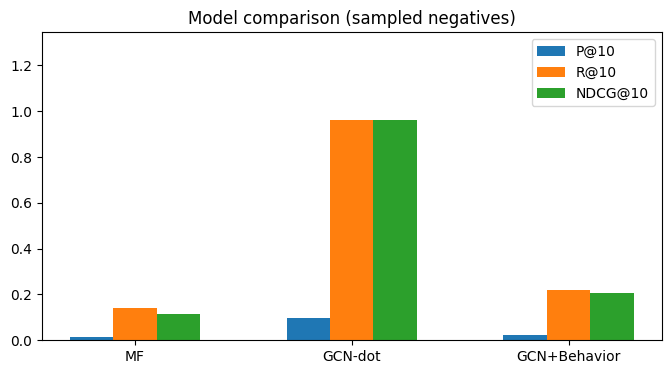

In [34]:
import matplotlib.pyplot as plt

def print_results(tag, d):
    print(tag)
    for k,v in d.items():
        print(f"  {k}: {v:.4f}")
    print()

print_results("MF", res_mf)
print_results("GCN-dot", res_gcn)
print_results("GCN+Behavior", res_gb)

# Simple bar chart for P@10
methods = ["MF","GCN-dot","GCN+Behavior"]
p10 = [res_mf["P@10"], res_gcn["P@10"], res_gb["P@10"]]
r10 = [res_mf["R@10"], res_gcn["R@10"], res_gb["R@10"]]
ndcg10 = [res_mf["NDCG@10"], res_gcn["NDCG@10"], res_gb["NDCG@10"]]

x = np.arange(len(methods))
plt.figure(figsize=(8,4))
plt.bar(x-0.2, p10, width=0.2, label="P@10")
plt.bar(x, r10, width=0.2, label="R@10")
plt.bar(x+0.2, ndcg10, width=0.2, label="NDCG@10")
plt.xticks(x, methods)
plt.ylim(0, max(max(p10), max(r10), max(ndcg10))*1.4 + 1e-6)
plt.legend()
plt.title("Model comparison (sampled negatives)")
plt.show()


In [35]:
# Try different feature subsets: ['avg_speed'], ['avg_completion'], ['total_watch_time'], ['speed+comp'], ['all']
col_options = {
    "speed": ["avg_speed"],
    "completion": ["avg_completion"],
    "time": ["total_watch_time"],
    "speed+comp": ["avg_speed","avg_completion"],
    "all": feat_cols  # from earlier
}

ablation_results = {}
for name, cols in col_options.items():
    print("Ablation:", name)
    # build X_user_scaled for these cols
    X_sub = users_df.set_index("user_id").reindex([idx2user[i] for i in range(num_users)])[cols].fillna(0).values
    X_sub_scaled = StandardScaler().fit_transform(X_sub)
    user_feat_tensor_sub = torch.tensor(X_sub_scaled, dtype=torch.float32, device=DEVICE)
    # quick small model (reuse ScoreModel architecture)
    model_sub = ScoreModel(emb_dim=concept_embs_np.shape[1], user_feat_dim=user_feat_tensor_sub.shape[1], hidden=128).to(DEVICE)
    opt_sub = torch.optim.Adam(model_sub.parameters(), lr=0.001, weight_decay=1e-5)
    loader_sub = make_score_loader(train_pairs, num_concepts, neg_ratio=4, batch_size=2048)
    # train short
    for epoch in range(4):
        model_sub.train()
        for batch in loader_sub:
            u_idx, c_idx, labels = batch
            u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
            c_idx = torch.tensor(c_idx, dtype=torch.long, device=DEVICE)
            labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)
            u_emb = user_emb_tensor[u_idx]
            c_emb = concept_emb_tensor[c_idx]
            u_feat = user_feat_tensor_sub[u_idx]
            preds = model_sub(u_emb, c_emb, u_feat)
            loss = bce(preds, labels)
            opt_sub.zero_grad(); loss.backward(); opt_sub.step()
    # evaluate
    def model_sub_fn(u, item_list):
        u_emb = user_emb_tensor[u:u+1]
        u_feat = user_feat_tensor_sub[u:u+1]
        c_embs = concept_emb_tensor[item_list]
        with torch.no_grad():
            sc = model_sub(u_emb.repeat(len(item_list),1), c_embs, u_feat.repeat(len(item_list),1)).cpu().numpy()
        return sc
    res = evaluate_ranking_scores(model_sub_fn, test_pairs, train_user_pos, num_concepts, K_list=[10], negatives=200)
    ablation_results[name] = res
    print(name, res)
print("Ablation done:", ablation_results)


Ablation: speed


/tmp/ipython-input-1523415671.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-1523415671.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_idx = torch.tensor(c_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-1523415671.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)
100%|██████████| 50/50 [00:00<00:00, 869.56it/s]
/tmp/ipython-input-1523415671.py:26: UserWarning: To copy 

speed {'P@10': 0.019999999999999997, 'R@10': 0.2, 'NDCG@10': 0.18578129652635775}
Ablation: completion


100%|██████████| 50/50 [00:00<00:00, 802.33it/s]
/tmp/ipython-input-1523415671.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-1523415671.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_idx = torch.tensor(c_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-1523415671.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)


completion {'P@10': 0.016, 'R@10': 0.16, 'NDCG@10': 0.16}
Ablation: time


100%|██████████| 50/50 [00:00<00:00, 999.67it/s]
/tmp/ipython-input-1523415671.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-1523415671.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_idx = torch.tensor(c_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-1523415671.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)


time {'P@10': 0.019999999999999997, 'R@10': 0.2, 'NDCG@10': 0.2}
Ablation: speed+comp


100%|██████████| 50/50 [00:00<00:00, 748.21it/s]
/tmp/ipython-input-1523415671.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_idx = torch.tensor(u_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-1523415671.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_idx = torch.tensor(c_idx, dtype=torch.long, device=DEVICE)
/tmp/ipython-input-1523415671.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=DEVICE)


speed+comp {'P@10': 0.016, 'R@10': 0.16, 'NDCG@10': 0.14602059991327962}
Ablation: all


100%|██████████| 50/50 [00:00<00:00, 492.80it/s]

all {'P@10': 0.013999999999999999, 'R@10': 0.14, 'NDCG@10': 0.14}
Ablation done: {'speed': {'P@10': 0.019999999999999997, 'R@10': 0.2, 'NDCG@10': 0.18578129652635775}, 'completion': {'P@10': 0.016, 'R@10': 0.16, 'NDCG@10': 0.16}, 'time': {'P@10': 0.019999999999999997, 'R@10': 0.2, 'NDCG@10': 0.2}, 'speed+comp': {'P@10': 0.016, 'R@10': 0.16, 'NDCG@10': 0.14602059991327962}, 'all': {'P@10': 0.013999999999999999, 'R@10': 0.14, 'NDCG@10': 0.14}}


In [36]:
# Save trained models
torch.save(mf_model.state_dict(), os.path.join(DATA_DIR,"mf_model.pth"))
torch.save(score_model.state_dict(), os.path.join(DATA_DIR,"gcn_behavior_model.pth"))

# Save evaluation results
import json
results_all = {"MF": res_mf, "GCN-dot": res_gcn, "GCN+Behavior": res_gb, "ablation": ablation_results}
with open(os.path.join(DATA_DIR,"evaluation_results.json"), "w") as f:
    json.dump(results_all, f, indent=2)
print("Saved models and results to", DATA_DIR)


Saved models and results to /content/data
